# Annotating the WebUI dataset

The WebUI dataset is very useful as it is, specially after having been processed in `scripts/process_webui.py` so that each bounding box can be handled individually. However, the classes/tags that are provided in the dataset are not very informative. This notebook aims to annotate the dataset with more informative tags.

## Further filtering

We should first apply some reasonable heuristics to reduce the number of superfluous bounding boxes.

In [69]:
from pathlib import Path
import json
from tqdm import tqdm
from typing import Tuple

In [70]:
sites = Path("../downloads/default_1280-720/")

In [71]:
sites_list = list(sites.iterdir())
print(f"{len(sites_list)} sites")
n_bbs = 0
for site in sites_list:
    n_bbs += len(list((site / "bounding_boxes").iterdir()))
print(f"{n_bbs} bounding boxes")

3986 sites
68103 bounding boxes


Let's begin by deleting all the bounding boxes that are not within the image resolution of 1280x720.

In [57]:
deleted = 0
for site in tqdm(sites_list):
    bounding_boxes_path = site / "bounding_boxes"
    bounding_boxes = list(bounding_boxes_path.iterdir())
    bounding_box_data = {}

    for bounding_box in bounding_boxes:
        with open(bounding_box) as f:
            bounding_box_data[bounding_box] = json.load(f)

    for bounding_box in bounding_boxes:
        data = bounding_box_data[bounding_box]
        if data["bounding_box"]["x"] + data["bounding_box"]["width"] > 1280 or data["bounding_box"]["y"] + data["bounding_box"]["height"] > 720:
            bounding_box.unlink()
            deleted += 1
print(f"Deleted {deleted} bounding boxes")

100%|██████████| 3986/3986 [00:56<00:00, 70.73it/s] 

Deleted 279002 bounding boxes


Let's first get rid of the bounding boxes that are too small. We can consider a box as "too small" if its less than the min_size defined below. Some of these are dots or lines. We don't want those.

In [67]:
image_area = 1280 * 720
threshold = 0.0003
min_area = int(image_area * threshold)
deleted = 0
for site in tqdm(sites_list):
    for bb in (site / "bounding_boxes").iterdir():
        with open(bb, "r") as f:
            data = json.load(f)
        # calculate the area of the bounding box
        width = data["bounding_box"]["width"]
        height = data["bounding_box"]["height"]
        area = width * height
        if area < min_area or width < 5 or height < 5:
            bb.unlink()
            deleted += 1
print(f"Deleted {deleted} bounding boxes")

100%|██████████| 3986/3986 [00:05<00:00, 727.57it/s]

Deleted 39 bounding boxes


Now let's delete the boxes that overlap. Those would confuse the detection model.

In [62]:
def overlap(box_a: dict, box_b: dict) -> Tuple[bool, Path]:
    overlaps = not (box_a["x"] + box_a["width"] <= box_b["x"] or
                    box_a["x"] >= box_b["x"] + box_b["width"] or
                    box_a["y"] + box_a["height"] <= box_b["y"] or
                    box_a["y"] >= box_b["y"] + box_b["height"])
    
    if overlaps:
        area_a = box_a["width"] * box_a["height"]
        area_b = box_b["width"] * box_b["height"]
        return overlaps, box_a if area_a >= area_b else box_b
    else:
        return overlaps, None

deleted_files = set()

for site in tqdm(sites_list):
    bounding_boxes_path = site / "bounding_boxes"
    bounding_boxes = list(bounding_boxes_path.iterdir())
    bounding_box_data = {}

    for bounding_box in bounding_boxes:
        with open(bounding_box) as f:
            bounding_box_data[bounding_box] = json.load(f)

    for bounding_box in bounding_boxes:
        if bounding_box in deleted_files:
            continue
        data = bounding_box_data[bounding_box]

        for bounding_box_2 in bounding_boxes:
            if bounding_box_2 in deleted_files or bounding_box in deleted_files:
                continue
            if bounding_box != bounding_box_2:
                data_2 = bounding_box_data[bounding_box_2]
                overlaps, larger_box = overlap(data["bounding_box"], data_2["bounding_box"])
                if overlaps:
                    larger_box_path = bounding_box if larger_box == data["bounding_box"] else bounding_box_2
                    larger_box_path.unlink()
                    deleted_files.add(larger_box_path)
                    break

100%|██████████| 3986/3986 [00:25<00:00, 155.00it/s]


In [63]:
print(f"Deleted {len(deleted_files)} bounding boxes")

Deleted 122761 bounding boxes


In [103]:
print(f"{len(list(sites.iterdir()))} sites")
sites_list = list(sites.iterdir())
n_bbs = 0
for site in sites_list:
    n_bbs += len(list((site / "bounding_boxes").iterdir()))
print(f"{n_bbs} bounding boxes")

3986 sites
68103 bounding boxes


Ok - so now we have about ~15% of what we started with. Let's store this.

In [110]:
import zipfile
import os

output_zip_path = Path('../downloads/balanced_7k_processed_filtered.zip')
base_output_path = Path("../downloads/default_1280-720")

with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(base_output_path):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, base_output_path))

In [109]:
from google.cloud import storage

bucket_name = "processed_webui"
source_file_name = "../downloads/balanced_7k_processed_filtered.zip"
destination_blob_name = "balanced_7k_processed_filtered.zip"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename(source_file_name)
print(f"File {source_file_name} uploaded to {destination_blob_name}.")


File ../downloads/balanced_7k_processed_filtered.zip uploaded to balanced_7k_processed_filtered.zip.


In [85]:
# choose a random site

import random
site = random.choice(sites_list)
print(site)

../downloads/default_1280-720/1656053961399


In [86]:
# get randome bounding box from that site
bounding_box = random.choice(list((site / "bounding_boxes").iterdir()))
print(bounding_box)
bounding_box_data = json.load(open(bounding_box))
bounding_box_data

../downloads/default_1280-720/1656053961399/bounding_boxes/103.json


{'tags': '',
 'bounding_box': {'x': 1053.09375, 'y': 42.078125, 'width': 90, 'height': 24}}

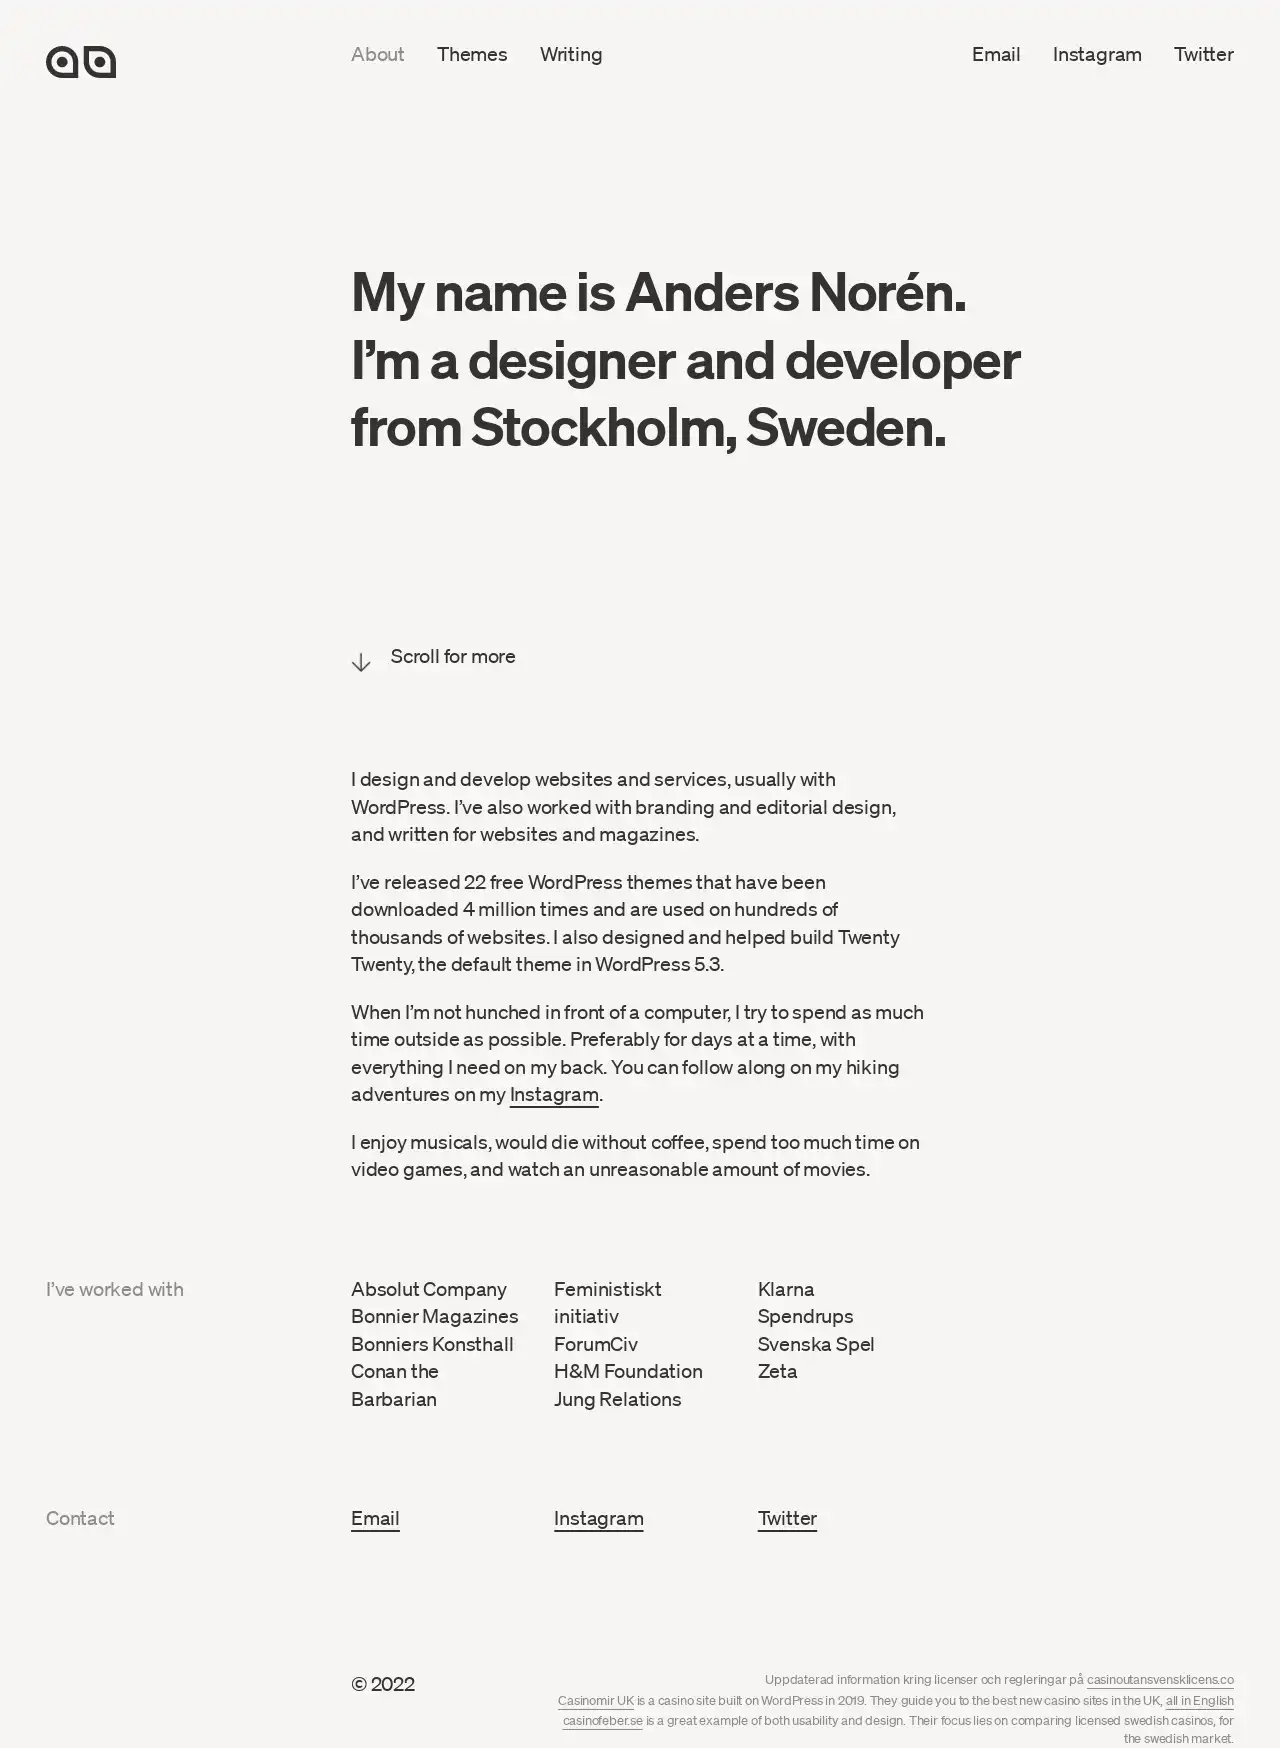

In [95]:
# read image
from PIL import Image

image = Image.open(site / "images" / "full-screenshot.webp")
image

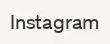

In [96]:
# crop image around bounding box + 10 pixels
image = image.crop((bounding_box_data["bounding_box"]["x"] - 10, bounding_box_data["bounding_box"]["y"] - 10, bounding_box_data["bounding_box"]["x"] + bounding_box_data["bounding_box"]["width"] + 10, bounding_box_data["bounding_box"]["y"] + bounding_box_data["bounding_box"]["height"] + 10))
image

In [99]:
# save image as jpeg
image.save("../downloads/cropped_image.jpg", "JPEG")

Using site `1656053961399` and bounding box 13 as an example we get this cropped image:

![](../downloads/cropped_image.jpg)

If we send this to the PaliGemma model fine-tuned on the WidgetCap dataset (https://huggingface.co/google/paligemma-3b-ft-widgetcap-448), we can get the OCR, caption and widget-type classification.

In this case, the model predicts the following:

- OCR: "Instagram"
- Caption: "go to instagram"
- Widget type: "text"

To replicate test run see: https://colab.research.google.com/drive/1WbWDFTUskZtikBatA5XY4U7q6ht_XjCm?usp=sharing

This is not bad, it will get us a long way. It might be worth considering doing the annotations with GPT-4o but that would be costly.

However, on a Nvidia T4 GPU this is taking about 2.6 seconds. Given that we have ~68k bounding boxes, that would take ~147 hours if done sequentially.

Improvements:

### Run quantized model

Uses 4-bit quantization and bfloat16. See: https://colab.research.google.com/drive/1kO9yvH2Ks7uH0GiWkM6_Q3Gqm0pBSqrb?usp=sharing

With this, the inference goes down to ~2.2 seconds. That's a 15% improvement. That would take ~124 hours.

### Run in parallel.

Using a 3-GPU machine would allow us to run the tasks in parallel. That would take ~41 hours.

### Using a bigger GPU

Using an instance with 2 L4 GPUs would allow us to run at least 2 task in parallel and use a bigger batch size.

TODO:

- Iterate over boxes and caption/ocr/classify with PaliGemma
- Clean data. If image remove OCR, if class = ocr | caption then remove class.

- add visualization